Converged after 4 iterations
Solving time step 0/999, progress: 0.0%
Solving time step 100/999, progress: 10.0%
Solving time step 200/999, progress: 20.0%
Solving time step 300/999, progress: 30.0%
Solving time step 400/999, progress: 40.0%
Solving time step 500/999, progress: 50.1%
Solving time step 600/999, progress: 60.1%
Solving time step 700/999, progress: 70.1%
Solving time step 800/999, progress: 80.1%
Solving time step 900/999, progress: 90.1%


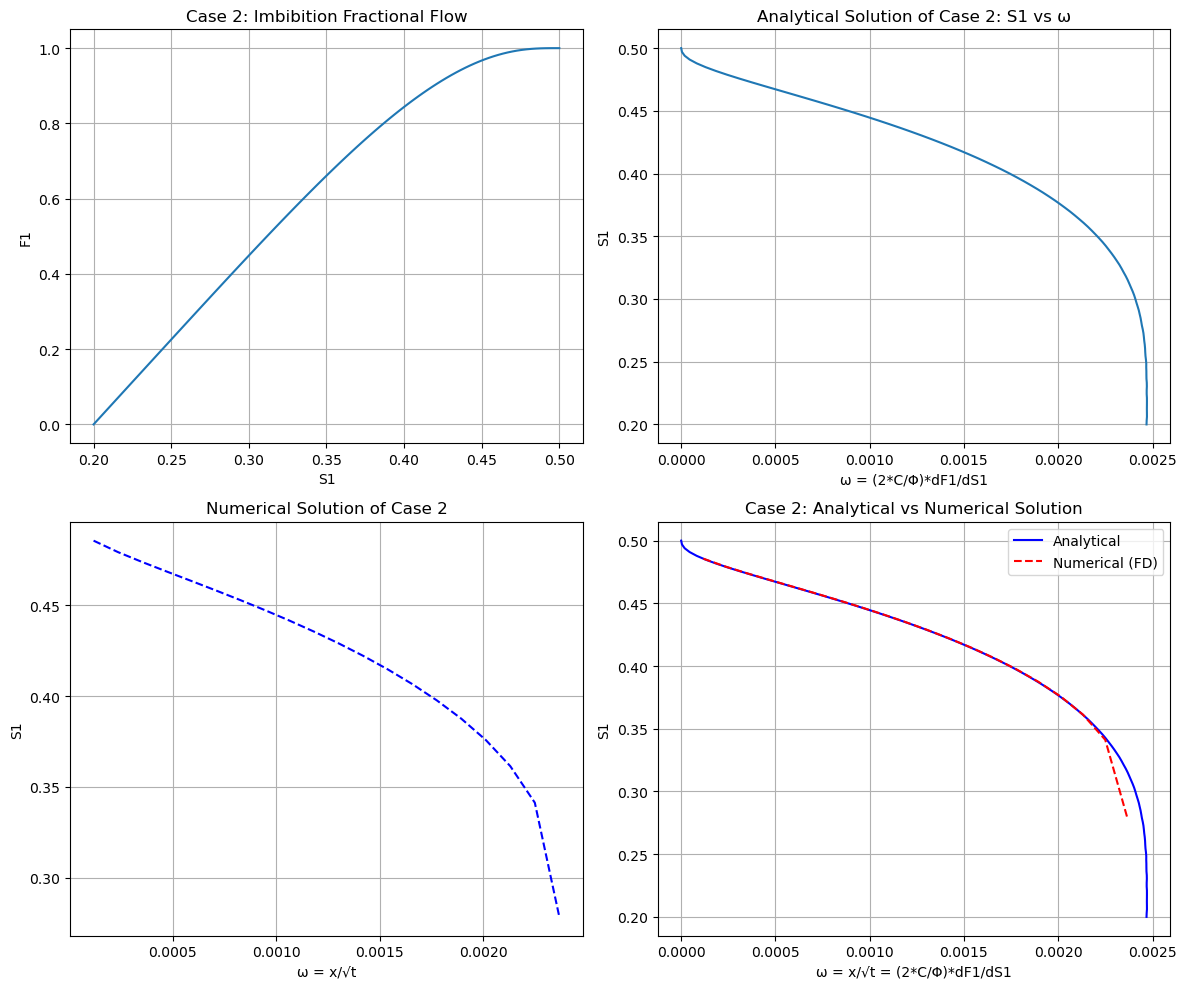

Converged after 4 iterations
Solving time step 0/999, progress: 0.0%
Solving time step 100/999, progress: 10.0%
Solving time step 200/999, progress: 20.0%
Solving time step 300/999, progress: 30.0%
Solving time step 400/999, progress: 40.0%
Solving time step 500/999, progress: 50.1%
Solving time step 600/999, progress: 60.1%
Solving time step 700/999, progress: 70.1%
Solving time step 800/999, progress: 80.1%
Solving time step 900/999, progress: 90.1%


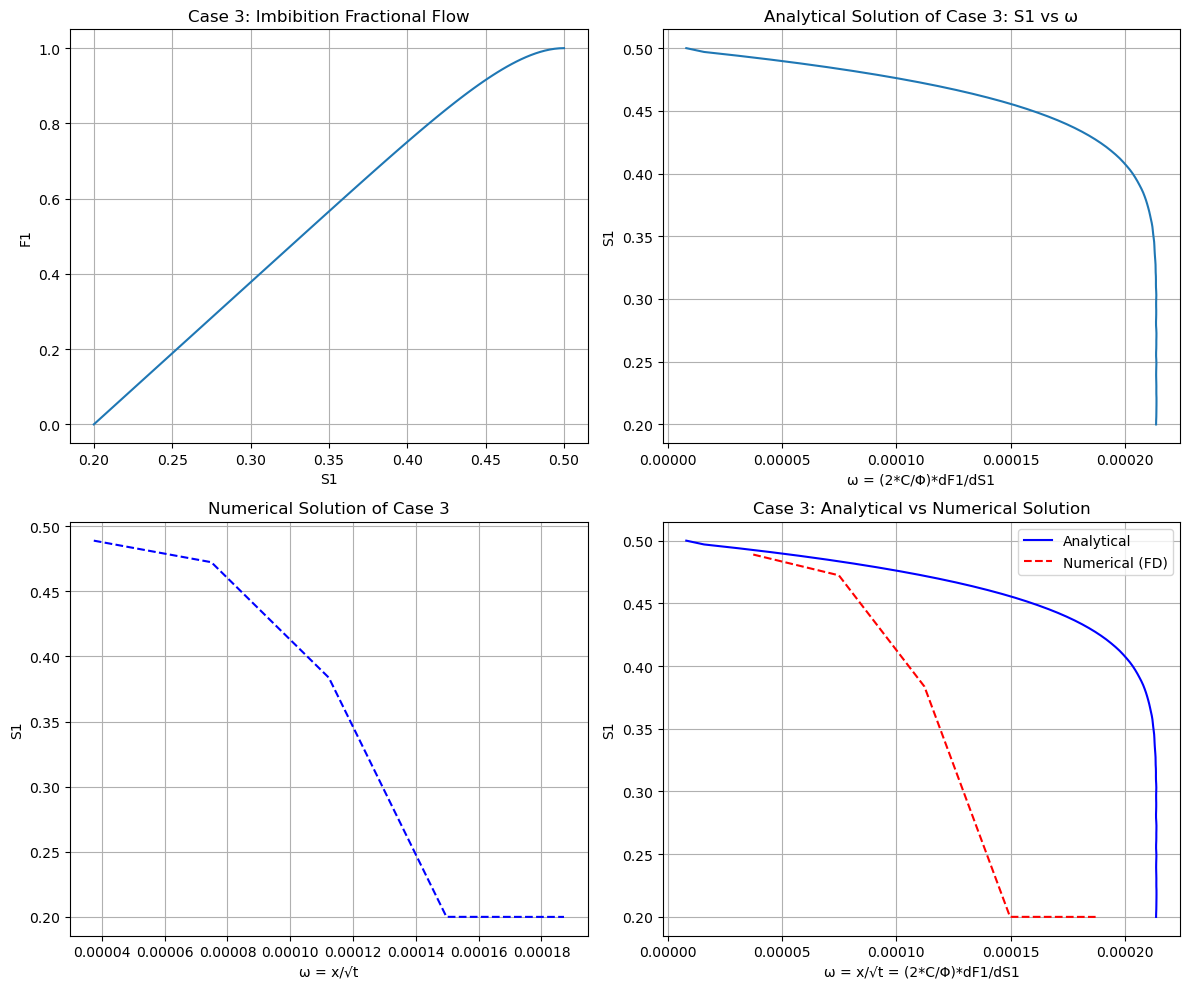

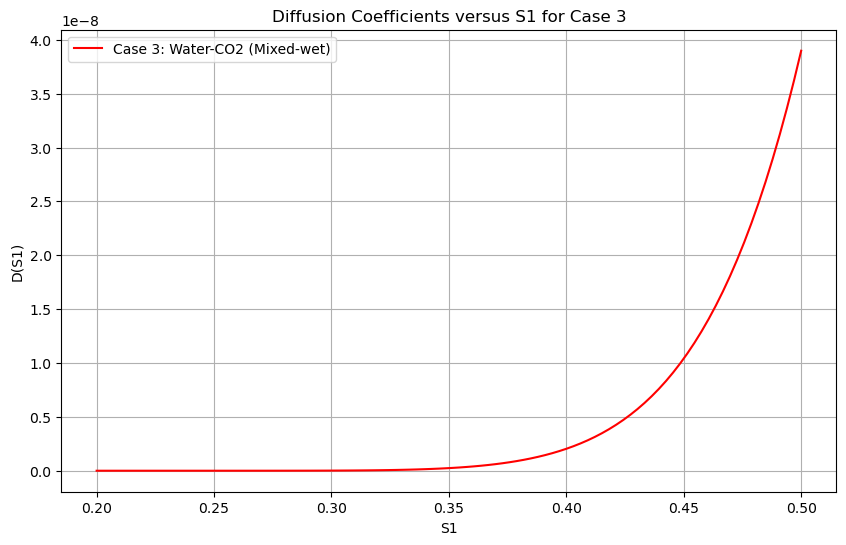

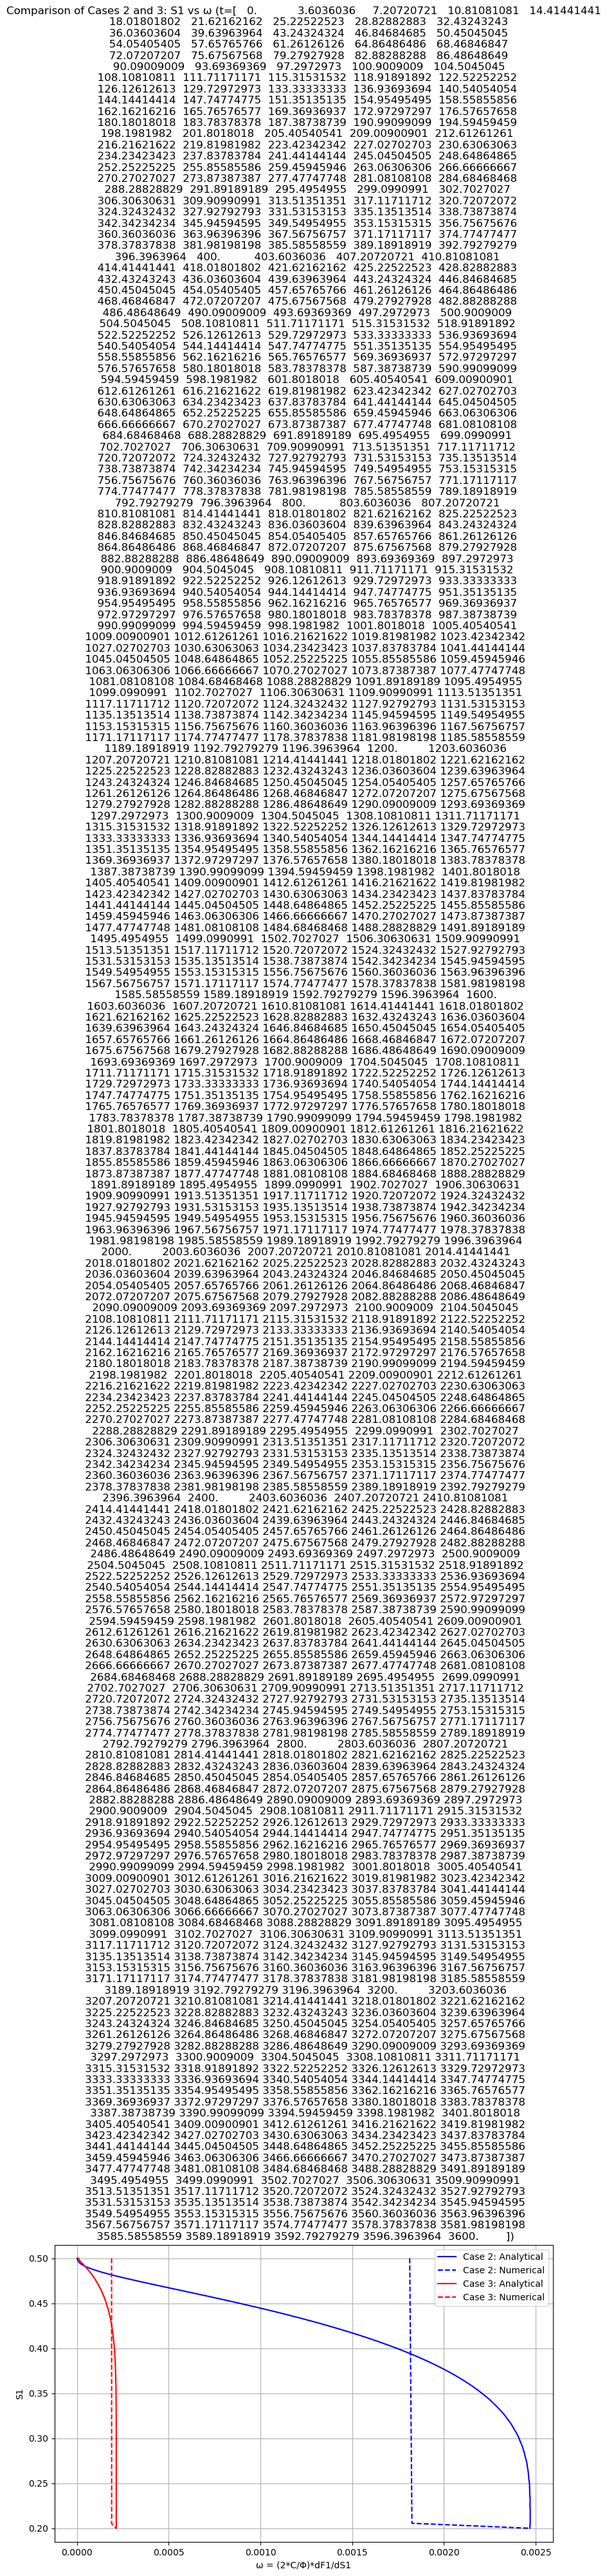

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d

# Define parameters for Cases 2 and 3
cases = {
    2: {
        "name": "Water displacing hydrogen",
        "mu1": 1e-3,            # Pa·s
        "mu2": 0.1e-3,          # Pa·s
        "kr1_max": 0.15,
        "kr2_max": 1.0,
        "a": 4,
        "b": 1.5,
        "S1i": 0.2,
        "S2r": 0.5,
        "K": 1e-13,             # m²
        "phi": 0.25,
        "Pc_max": 100e3,        # Pa
        "c": 0.3,
        "S1_star": 0.5
    },
    3: {
        "name": "Water displacing CO2 (mixed-wet)",
        "mu1": 0.4e-3,          # Pa·s
        "mu2": 0.1e-3,          # Pa·s
        "kr1_max": 0.4,
        "kr2_max": 0.8,
        "a": 8,
        "b": 3,
        "S1i": 0.2,
        "S2r": 0.15,
        "K": 1e-13,             # m²
        "phi": 0.25,
        "Pc_max": 100e3,        # Pa
        "c": 0.3,
        "S1_star": 0.5
    }
}

def calculate_Se(S1, S1i, S2r):
    """Calculate the effective saturation."""
    return (S1 - S1i) / (1 - S2r - S1i)

def calculate_kr1(Se, kr1_max, a):
    """Calculate relative permeability of phase 1."""
    return kr1_max * Se**a

def calculate_kr2(Se, kr2_max, b):
    """Calculate relative permeability of phase 2."""
    return kr2_max * (1 - Se)**b

def calculate_Pc(S1, S1i, S1_star, Pc_max, c):
    """Calculate capillary pressure."""
    term1 = (S1_star/S1i)**(-c)
    term2 = (S1/S1i)**(-c)
    Pc = Pc_max * (term1 - term2) / (term1 - 1)
    return max(0, Pc)  # Ensure Pc is non-negative

def calculate_dPc_dS1(S1, S1i, S1_star, Pc_max, c):
    """Calculate derivative of capillary pressure with respect to S1."""
    term1 = (S1_star/S1i)**(-c)
    term2 = (S1/S1i)**(-c)
    
    # Calculate the derivative
    dterm2_dS1 = (-c) * (S1/S1i)**(-c-1) * (1/S1i)
    dPc_dS1 = Pc_max * (-dterm2_dS1) / (term1 - 1)
    
    return dPc_dS1

def calculate_D(S1, params):
    """Calculate the diffusion coefficient D."""
    S1i, S2r = params["S1i"], params["S2r"]
    kr1_max, kr2_max = params["kr1_max"], params["kr2_max"]
    a, b = params["a"], params["b"]
    mu1, mu2 = params["mu1"], params["mu2"]
    K = params["K"]
    Pc_max, c = params["Pc_max"], params["c"]
    S1_star = params["S1_star"]
    
    Se = calculate_Se(S1, S1i, S2r)
    kr1 = calculate_kr1(Se, kr1_max, a)
    kr2 = calculate_kr2(Se, kr2_max, b)
    
    dPc_dS1 = calculate_dPc_dS1(S1, S1i, S1_star, Pc_max, c)
    
    # Calculate D
    numerator = kr1 / mu1 * kr2 / mu2
    denominator = kr1 / mu1 + kr2 / mu2
    
    # Handle division by zero
    if denominator == 0:
        return 0
    
    D = -numerator / denominator * K * dPc_dS1
    return D

def iterate_F1(S1_values, params, max_iterations=10):
    """Iterate to find F1 using the procedure described in the problem."""
    S1i = params["S1i"]
    S1_star = params["S1_star"]
    phi = params["phi"]
    
    # Initial guess for F1
    F1 = np.zeros_like(S1_values)
    for i, S1 in enumerate(S1_values):
        if S1 < S1i:
            F1[i] = 0
        elif S1 > S1_star:
            F1[i] = 1
        else:
            F1[i] = (S1 - S1i) / (S1_star - S1i)
    
    for iteration in range(max_iterations):
        # Calculate C^2
        def integrand_C2(beta, S1i, F1_func, D_func):
            return (beta - S1i) * D_func(beta) / F1_func(beta)
        
        # Create interpolation functions for F1 and D
        F1_func = interp1d(S1_values, F1, bounds_error=False, fill_value=(0, 1))
        
        def D_func(S1):
            return calculate_D(S1, params)
        
        # Calculate C^2 using numerical integration
        C2 = phi / 2 * quad(
            lambda beta: integrand_C2(beta, S1i, F1_func, D_func),
            S1i, S1_star
        )[0]
        
        # Update F1 values for each S1
        F1_new = np.zeros_like(F1)
        for i, S1 in enumerate(S1_values):
            if S1 < S1i:
                F1_new[i] = 0
            elif S1 > S1_star:
                F1_new[i] = 1
            else:
                # Calculate the integral for updating F1
                def integrand_F1(beta, S1, F1_func, D_func):
                    return (beta - S1) * D_func(beta) / F1_func(beta)
                
                integral = quad(
                    lambda beta: integrand_F1(beta, S1, F1_func, D_func),
                    S1, S1_star
                )[0]
                
                F1_new[i] = 1 - phi / (2 * C2) * integral
        
        # Check for convergence
        if np.allclose(F1, F1_new, rtol=1e-4):
            print(f"Converged after {iteration+1} iterations")
            break
        
        F1 = F1_new
    
    return F1, C2

def calculate_omega(S1_values, F1_values, C2, phi):
    """Calculate omega for each S1 value using the correct formula: ω = (2*C/Φ) * dF1/dS1."""
    # Calculate dF1/dS1 using central differences
    dF1_dS1 = np.zeros_like(S1_values)
    
    # Use central difference for interior points
    for i in range(1, len(S1_values) - 1):
        dF1_dS1[i] = (F1_values[i+1] - F1_values[i-1]) / (S1_values[i+1] - S1_values[i-1])
    
    # Use forward difference for the first point
    dF1_dS1[0] = (F1_values[1] - F1_values[0]) / (S1_values[1] - S1_values[0])
    
    # Use backward difference for the last point
    dF1_dS1[-1] = (F1_values[-1] - F1_values[-2]) / (S1_values[-1] - S1_values[-2])
    
    # Calculate omega using the CORRECT formula
    C = np.sqrt(C2)
    omega = (2 * C / phi) * dF1_dS1
    
    return omega

def calculate_omega_from_numerical(S1_fd, x_fd, t, C2, phi, S1_values, F1_values):
    """Calculate omega values for the numerical solution using the correct formula."""
    # Interpolate F1 values for the numerical solution's S1 values
    F1_interp = interp1d(S1_values, F1_values, bounds_error=False, fill_value=(0, 1))
    F1_fd = F1_interp(S1_fd)
    
    # Calculate dF1/dS1 using central differences
    dF1_dS1_fd = np.zeros_like(S1_fd)
    
    # Calculate dF1/dx using central differences
    dF1_dx = np.zeros_like(F1_fd)
    for i in range(1, len(F1_fd) - 1):
        dF1_dx[i] = (F1_fd[i+1] - F1_fd[i-1]) / (x_fd[i+1] - x_fd[i-1])
    
    # Use forward difference for the first point
    dF1_dx[0] = (F1_fd[1] - F1_fd[0]) / (x_fd[1] - x_fd[0])
    
    # Use backward difference for the last point
    dF1_dx[-1] = (F1_fd[-1] - F1_fd[-2]) / (x_fd[-1] - x_fd[-2])
    
    # Calculate dS1/dx using central differences
    dS1_dx = np.zeros_like(S1_fd)
    for i in range(1, len(S1_fd) - 1):
        dS1_dx[i] = (S1_fd[i+1] - S1_fd[i-1]) / (x_fd[i+1] - x_fd[i-1])
    
    # Use forward difference for the first point
    dS1_dx[0] = (S1_fd[1] - S1_fd[0]) / (x_fd[1] - x_fd[0])
    
    # Use backward difference for the last point
    dS1_dx[-1] = (S1_fd[-1] - S1_fd[-2]) / (x_fd[-1] - x_fd[-2])
    
    # Calculate dF1/dS1 using chain rule: dF1/dS1 = (dF1/dx) / (dS1/dx)
    # Avoid division by zero
    for i in range(len(dF1_dS1_fd)):
        if abs(dS1_dx[i]) > 1e-10:
            dF1_dS1_fd[i] = dF1_dx[i] / dS1_dx[i]
        else:
            # Use nearby values or set to zero if dS1/dx is too small
            if i > 0:
                dF1_dS1_fd[i] = dF1_dS1_fd[i-1]
            else:
                dF1_dS1_fd[i] = 0
    
    # Calculate omega using the correct formula
    C = np.sqrt(C2)
    omega_fd = (2 * C / phi) * dF1_dS1_fd
    
    return omega_fd

def numerical_solution_fd(params, S1i, S1_star, nx=100, nt=1000, T=1.0, L=1.0):
    """Solve the spontaneous imbibition equation using finite differences with adaptive time stepping."""
    phi = params["phi"]
    
    # Set up grid
    dx = L / nx
    dt_init = T / nt
    dt = dt_init
    
    x = np.linspace(0, L, nx+1)
    
    # Initialize solution array
    S1 = np.ones(nx+1) * S1i
    S1[0] = S1_star  # Boundary condition at x=0
    
    # Time stepping with adaptive time step
    t_elapsed = 0
    while t_elapsed < T:
        # Calculate maximum diffusion coefficient for stability
        max_D = max([calculate_D(s, params) for s in S1])
        
        # Adjust time step for stability (with safety factor 0.4)
        if max_D > 1e-16:  # Avoid division by very small values
            dt_stable = 0.4 * phi * dx**2 / max_D
            dt = min(dt_init, dt_stable)
        else:
            # If diffusion is very low, use larger time steps but cap at original dt
            dt = dt_init
        
        # Make sure we don't exceed total time
        if t_elapsed + dt > T:
            dt = T - t_elapsed
        
        # Apply finite difference scheme for interior points
        S1_new = S1.copy()
        for i in range(1, nx):
            # Calculate D at cell centers
            D_iminus = calculate_D((S1[i-1] + S1[i])/2, params)
            D_iplus = calculate_D((S1[i] + S1[i+1])/2, params)
            
            # Explicit scheme
            S1_new[i] = S1[i] + dt/phi * (
                (D_iplus * (S1[i+1] - S1[i]) - D_iminus * (S1[i] - S1[i-1])) / dx**2
            )
        
        # Update for next time step
        S1 = S1_new.copy()
        t_elapsed += dt
    
    return x, S1

def calculate_omega_numerical(x_fd, t_fd):
    """
    Calculate and return the array of omega values given x_fd and t_fd,
    where omega = x_fd / sqrt(t_fd).

    Parameters:
      x_fd : numpy array
          Array of spatial positions.
      t_fd : scalar or numpy array
          Time value(s). Must be positive.

    Returns:
      omega : numpy array
          If t_fd is scalar, returns a 1D array: omega = x_fd/sqrt(t_fd).
          If t_fd is an array of shape (nt,), returns a 2D array of shape (nt, len(x_fd))
          with omega[i, :] = x_fd / sqrt(t_fd[i]).
    """
    # Ensure that all time values are positive
    if np.isscalar(t_fd):
        if t_fd <= 0:
            raise ValueError("t_fd must be positive.")
        return x_fd / np.sqrt(t_fd)
    else:
        t_fd = np.array(t_fd)
        if np.any(t_fd <= 0):
            raise ValueError("All time values in t_fd must be positive.")
        # Broadcasting: reshape x_fd to (1, nx) and t_fd to (nt, 1)
        omega = x_fd[None, :] / np.sqrt(t_fd)[:, None]
        return omega

def solve_imbibition_FD(params, L=1.0, T=None, nx=200, nt=1000):
    """Solve the spontaneous imbibition equation using finite differences"""
    # Adjust simulation time based on diffusion coefficient magnitude
    if T is None:
        # Check average diffusion coefficient to set appropriate time scale
        S1_range = np.linspace(params['S1i'], params['S1_star'], 20)
        avg_D = np.mean([calculate_D(s, params) for s in S1_range])
        
        # Set time based on diffusion speed - slower diffusion needs longer time
        if avg_D < 1e-8:  # Very small diffusion (like Case 3)
            T = 36000  # 10x longer for slow diffusion
        else:
            T = 3600  # Default time for normal diffusion
    
    # Initialize grid
    dx = L / (nx - 1)
    dt = T / nt
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt)
    
    # Initialize solution array
    S = np.ones((nt, nx)) * params['S1i']
    
    # Set boundary condition at x=0
    S[:, 0] = params['S1_star']
    
    # Implicit scheme (Crank-Nicolson)
    for n in range(0, nt-1):
        # Create coefficient matrix and right-hand side
        A = np.zeros((nx, nx))
        b = np.zeros(nx)
        
        # Interior points
        for i in range(1, nx-1):
            # Get diffusion coefficient at current state
            D_iminus = calculate_D(0.5 * (S[n, i-1] + S[n, i]), params)
            D_iplus = calculate_D(0.5 * (S[n, i] + S[n, i+1]), params)
            
            # Add small regularization for very small diffusion coefficients
            D_iminus = max(D_iminus, 1e-16)  # Prevent numerical issues
            D_iplus = max(D_iplus, 1e-16)    # Prevent numerical issues
            
            # Coefficients for implicit scheme
            A[i, i-1] = -dt * D_iminus / (2 * params['phi'] * dx**2)
            A[i, i] = 1 + dt * (D_iminus + D_iplus) / (2 * params['phi'] * dx**2)
            A[i, i+1] = -dt * D_iplus / (2 * params['phi'] * dx**2)
            
            # Right-hand side (explicit part)
            b[i] = S[n, i] + dt * (
                D_iminus * (S[n, i-1] - S[n, i]) / (2 * params['phi'] * dx**2) +
                D_iplus * (S[n, i+1] - S[n, i]) / (2 * params['phi'] * dx**2)
            )
        
        # Boundary conditions
        A[0, 0] = 1
        b[0] = params['S1_star']
        
        A[-1, -1] = 1
        A[-1, -2] = 0
        b[-1] = S[n, -1]
        
        # Solve system
        try:
            S[n+1, :] = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            # If matrix is ill-conditioned, add small regularization
            for i in range(nx):
                A[i, i] += 1e-10
            S[n+1, :] = np.linalg.solve(A, b)
        
        # Ensure physical bounds
        S[n+1, :] = np.clip(S[n+1, :], params['S1i'], params['S1_star'])
        
        # Monitor progress occasionally
        if n % (nt // 10) == 0:
            print(f"Solving time step {n}/{nt-1}, progress: {n/(nt-1)*100:.1f}%")
    
    return x, t, S


def solve_and_plot_case(case_number, plot_x_range=0.5):
    """Solve and plot the spontaneous imbibition problem for a specific case."""
    params = cases[case_number]
    
    # Set up saturation range for the analytical solution
    S1_values = np.linspace(params["S1i"], params["S1_star"], 100)
    
    # Step 1: Iterate to find F1
    F1_values, C2 = iterate_F1(S1_values, params)
    
    # Step 2: Calculate omega using the correct formula
    omega_values = calculate_omega(S1_values, F1_values, C2, params["phi"])
    
    # Step 3: Adjust simulation parameters based on case
    if case_number == 2:
        t = 0.1
        nt = 10000
    else:  # Case 3 needs much longer time due to lower diffusion coefficient
        t = 100.0  # 1000x longer simulation time
        nt = 100000  # More time steps for stability
    
    # Get numerical solution
    x_fd, S1_fd = numerical_solution_fd(params, params["S1i"], params["S1_star"], 
                                       nx=200, nt=nt, T=t, L=plot_x_range)

    # Step4: Solve imbibition using finite differences
    x, t, S_numerical = solve_imbibition_FD(params)

    # Calculate omega values for the numerical solution
    #omega_fd = calculate_omega_numerical(x_fd, t_fd)
    
    # Calculate omega values for the numerical solution
    omega_fd = calculate_omega_from_numerical(S1_fd, x_fd, t, C2, params["phi"], S1_values, F1_values)

    # For comparison at a specific time
    time_fraction = 0.5  # Use the solution at 50% of simulation time
    t_idx = int(len(t) * time_fraction)
    t_selected = t[t_idx]
    S_at_t = S_numerical[t_idx, :]

    # Convert x to omega for comparison with the correct formula
    # ω = x/√t = (2*C/φ) * dF1/dS1, so x = ω * √t
    omega_numerical = x / np.sqrt(t_selected)

    
    # Plotting
    plt.figure(figsize=(12, 10))
    
    # Plot F1 vs S1
    plt.subplot(2, 2, 1)
    plt.plot(S1_values, F1_values)
    plt.xlabel('S1')
    plt.ylabel('F1')
    plt.title(f'Case {case_number}: Imbibition Fractional Flow')
    plt.grid(True)
    
    # Plot S1 vs omega (using correct formula)
    plt.subplot(2, 2, 2)
    plt.plot(omega_values, S1_values)
    plt.xlabel('ω = (2*C/Φ)*dF1/dS1')
    plt.ylabel('S1')
    plt.title(f'Analytical Solution of Case {case_number}: S1 vs ω')
    plt.grid(True)

    valid_indices = (omega_numerical > 0) & (omega_numerical < np.max(omega_fd))
    
    # Plot numerical solution (S1 vs omega)
    plt.subplot(2, 2, 3)
    #plt.plot(omega_fd, S1_fd)
    plt.plot(omega_numerical[valid_indices], S_at_t[valid_indices], 'b--', label='Numerical')
    plt.xlabel('ω = x/√t')
    plt.ylabel('S1')
    plt.title(f'Numerical Solution of Case {case_number}')
    plt.grid(True)

    
    # Compare analytical and numerical solutions (S1 vs ω)
    plt.subplot(2, 2, 4)
    plt.plot(omega_values, S1_values, 'b-', label='Analytical')
    plt.plot(omega_numerical[valid_indices], S_at_t[valid_indices], 'r--', label='Numerical (FD)')
    plt.xlabel('ω = x/√t = (2*C/Φ)*dF1/dS1')
    plt.ylabel('S1')
    plt.title(f'Case {case_number}: Analytical vs Numerical Solution')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'case_{case_number}_imbibition_corrected.png', dpi=300)
    plt.show()
    
    # Return solution data for analysis
    return {
        'S1_values': S1_values,
        'F1_values': F1_values,
        'omega_values': omega_values,
        'C2': C2,
        'x_fd': x_fd,
        'S1_fd': S1_fd,
        'omega_fd': omega_fd,
        't': t
    }

# Solve and plot both cases
results_case2 = solve_and_plot_case(2)
results_case3 = solve_and_plot_case(3)

# Additional analysis: Compare D(S1) for both cases
plt.figure(figsize=(10, 6))
S1_range = np.linspace(0.2, 0.5, 100)
D_case2 = [calculate_D(s, cases[2]) for s in S1_range]
D_case3 = [calculate_D(s, cases[3]) for s in S1_range]

#plt.plot(S1_range, D_case2, 'b-', label='Case 2: Water-Hydrogen')
plt.plot(S1_range, D_case3, 'r-', label='Case 3: Water-CO2 (Mixed-wet)')
plt.xlabel('S1')
plt.ylabel('D(S1)')
plt.title('Diffusion Coefficients versus S1 for Case 3')
plt.legend()
plt.grid(True)
plt.savefig('diffusion_coefficient_comparison.png', dpi=300)
plt.show()

# Compare the solutions for Cases 2 and 3 (S1 vs ω)
plt.figure(figsize=(10, 6))
plt.plot(results_case2['omega_values'], results_case2['S1_values'], 'b-', label='Case 2: Analytical')
plt.plot(results_case2['omega_fd'], results_case2['S1_fd'], 'b--', label='Case 2: Numerical')
plt.plot(results_case3['omega_values'], results_case3['S1_values'], 'r-', label='Case 3: Analytical')
plt.plot(results_case3['omega_fd'], results_case3['S1_fd'], 'r--', label='Case 3: Numerical')
plt.xlabel('ω = (2*C/Φ)*dF1/dS1')
plt.ylabel('S1')
plt.title(f'Comparison of Cases 2 and 3: S1 vs ω (t={results_case2["t"]})')
plt.legend()
plt.grid(True)
plt.savefig('case_comparison_corrected.png', dpi=300)
plt.show()